# Generalization - GATR General vs Specific - Comparing Absolute Runtime

Generate figures to compare runtime of models

This notebook assumes that the following sets of experiments have already been collected (indicated by `Collected: {path}` below) using the scripts in `../run`. For instructions on how to run these scripts, please refer to `../example`. This notebook focuses solely on visualizing the results.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from IPython.core.display import HTML
from ast import literal_eval
import copy

from graph_attention_replanner.config import LogFileConfig
from matplotlib.colors import Normalize

import matplotlib.ticker as ticker
from matplotlib.patches import Patch
plt.rcParams["font.family"] = "sans-serif"

palette = sns.color_palette("ch:start=.2,rot=-.3", 5)
problem_colour = palette
problem_colour_hex = palette.as_hex()
os.system("mkdir -p ../../cache/plots")

0

In [3]:
method_presentable = {
    "gat_gen": "Ours",
    "gat": "Ours (Specifc)",
    "lkh": r'$\mathregular{NOpt_{lkh3}}$',
    "random": r'$\mathregular{Med_{s}}$',
}

problem_presentable = {
    1: "mTSP",
    2: "mTSP + Vary Task Time",
    3: "mTSP + Multiple Start Loc.",
    4: "mTSP + Vary Task Time \n+ Multiple Start Loc.",
    5: "mTSP + Vary Task Time \n+ Multiple Start Loc. \n+ Collaborative Tasking",
}

method_details = {
    "gat": "gat",
    "gat_gen": "gat_gen",
    "lkh": "lkh",
    "random": "random_101_cpu"
}

base_arg = {
    "mtsp_problem_type": 5,
    "batch_size": 1000,
    "batch_size_large": 10000,
}

num_task_list = [6]
num_agent_list = [6]
discretize_level_list = [1,2,4]

data_seeds = [10,11,12]
# Which model to evaulate on which data, here model 0 evaulate on data 10
method_seeds = {
    10: 0,
    11: 1,
    12: 2,
}


In [4]:
def remove_stem(path):
    parts = Path(path).parts
    idx = parts.index("cache")
    relative_path = Path(*parts[idx:]) 
    return relative_path

df_list = []
for data_seed in data_seeds:
    for num_task in num_task_list:
        for num_agent in num_agent_list:
            for discretize_level in discretize_level_list:
                num_node = num_task*discretize_level
                for method in ["gat_gen", "gat", "lkh"]:
                    for machine in ["cpu", "gpu", "pi"]:

                        bs = base_arg["batch_size_large"] if (method == "lkh" and machine=="gpu") else base_arg["batch_size"]

                        cfg = LogFileConfig(
                            base_arg["mtsp_problem_type"],
                            num_node,
                            num_task,
                            num_task,
                            discretize_level,
                            discretize_level,
                            num_agent,
                            num_agent,
                            bs,
                            read_only=True,
                        )
                        num_exp = 1 if (method == "gat" or method == "gat_gen" or method == "random") else bs
                        method_seed = method_seeds[data_seed] if (method == "gat" or method == "gat_gen") else None
                        file_name = method + "_" + machine
                        path = cfg.get_result_logfilename(
                            method=file_name,
                            format="csv",
                            num_exp=num_exp,
                            seed = data_seed,
                            method_seed = method_seed
                        )
                        if os.path.exists(path):
                            df = pd.read_csv(path)
                            df["method"] = method
                            df["Machine"] = machine
                            df["num_node"] = num_node
                            df["num_task"] = num_task
                            df["num_agent"] = num_agent
                            df["ratio"] = num_task*discretize_level/num_agent
                            df["discretize_level"] = discretize_level
                            df["seed"] = data_seed
                            df["method_seed"] = method_seed

                            # Filter away the extra experiments
                            df = df[df['exp_idx'] < base_arg["batch_size"]]
                            df_list.append(df)
                            print(f"Collected: {remove_stem(path)}")
                        else:
                            print(f"WARNING: File not found: {remove_stem(path)}")

MERGED_DF = pd.concat(df_list, ignore_index=True)

Collected: cache/results/gat_gen_cpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_gpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_pi/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_cpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_pi/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_cpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs1000_exp1000_dataseed10.csv
Collected: cache/results/lkh_gpu/problem5_node6_task6to6_dislevel1to1_agent6to6_bs10000_exp10000_dataseed10.csv
Collected: cache/results/lkh_pi/problem5_node6_task6to

In [5]:
def transform_df(df):
    df = df[(df["num_agent"] == 6) & (df["method"] != "random") & (df["Machine"] == "pi") & (df["num_node"] == 24)]
    df["Method"] = df["method"].replace(method_presentable, inplace=False)
    return df

df = transform_df(MERGED_DF)
# Pivot the data to summarise runtime by Machine and Method
table = df.pivot_table(
    index="Machine", 
    columns="method", 
    values="runtime", 
    aggfunc="mean"  # You can change this if needed (e.g., sum, median)
)
# Reset index for a cleaner display
table = table.reset_index()
table

/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_29981/929927881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Method"] = df["method"].replace(method_presentable, inplace=False)


method,Machine,gat,gat_gen,lkh
0,pi,0.159088,0.007417,2.746661


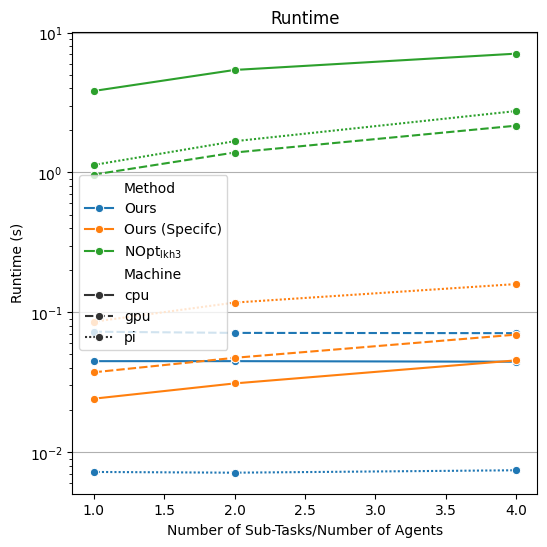

In [7]:
def transform_df(df):
    df = df[(df["num_agent"] == 6) & (df["method"] != "random")]
    df["Method"] = df["method"].replace(method_presentable, inplace=False)
    return df

df = transform_df(MERGED_DF)

fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(
    data=df, 
    x="ratio", 
    y="runtime", 
    hue="Method",
    style="Machine",
    ax=ax,
    err_style="bars",
    errorbar=("se", 2),
    marker='o',
)
plt.grid(axis = 'y')
ax.set(yscale='log')
ax.set_ylabel("Runtime (s)")
ax.set_xlabel("Number of Sub-Tasks/Number of Agents")
ax.set_title("Runtime")

fig.savefig("../../cache/plots/runtime.png", bbox_inches='tight')

/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_29981/111098877.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_method2["gap"] = combined_gat_gen["runtime"].values*100/(combined_gat_gen["runtime_lkh"].values)
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_29981/111098877.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_method2["method"] = method2
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_29981/111098877.py:20: SettingWithCopyWarning: 
A value is tryin

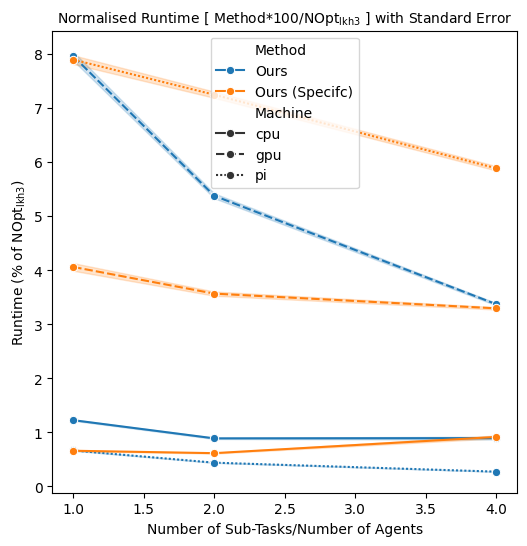

In [8]:
def transform_df(df):
    method2 = "gat_gen"
    method1 = "gat"
    against = "lkh"

    df = df[["Machine", "method", "num_agent", "num_task", "discretize_level", "mission_time", "seed", "exp_idx", "runtime"]]

    out_method2 = df[(df["method"]==method2)]
    out_method1 = df[(df["method"]==method1)]
    out_against = df[(df["method"]==against)]

    combined_gat_gen = pd.merge(out_method2, out_against, how='left', 
                        on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx", "Machine"], suffixes=("", "_lkh"))
    out_method2["gap"] = combined_gat_gen["runtime"].values*100/(combined_gat_gen["runtime_lkh"].values)
    out_method2["method"] = method2

    combined_gat = pd.merge(out_method1, out_against, how='left', 
                        on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx", "Machine"], suffixes=("", "_lkh"))
    out_method1["gap"] = (combined_gat["runtime"].values)*100/(combined_gat["runtime_lkh"].values)
    out_method1["method"] = method1

    output = pd.concat([out_method2, out_method1], ignore_index=True)
    output["num_node"] = output["num_task"]*output["discretize_level"]
    output["ratio"] = output["num_task"]*output["discretize_level"]/output["num_agent"]
    output["Method"] = output["method"].replace(method_presentable, inplace=False)
    return output

df = transform_df(MERGED_DF)
fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(
    data=df, 
    x="ratio", 
    y="gap", 
    hue="Method",
    style="Machine",
    ax=ax,
    errorbar=("se", 2),
    marker='o',
)

ax.set_ylabel(f"Runtime (% of {method_presentable['lkh']})")
ax.set_xlabel("Number of Sub-Tasks/Number of Agents")
title = f"Normalised Runtime [ Method*100/{method_presentable['lkh']} ] with Standard Error"
plt.title(title, fontsize=10)
plt.savefig("../../cache/plots/delta_runtime.png", bbox_inches='tight', dpi=300)